In [20]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import torch.optim as optim
from mlxtend.preprocessing import minmax_scaling
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, normalize, StandardScaler, Normalizer, RobustScaler
from sklearn.model_selection import train_test_split
%pip install torchviz
from torchviz import make_dot
from sklearn.impute import SimpleImputer

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\chris\titanic\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [21]:
df = pd.read_csv('train.csv')
df.drop(['Name', 'Ticket', 'Cabin'], inplace=True, axis=1)

In [22]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

In [23]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df['Age'].values.reshape(-1, 1))
df['Age'] = imp.transform(df['Age'].values.reshape(-1, 1))

In [24]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
dtype: int64

In [25]:
df.dropna(inplace=True)

In [26]:
df = pd.get_dummies(df, columns={'Sex'})
df = pd.get_dummies(df, columns={'Pclass'})
df = pd.get_dummies(df, columns={'Embarked'})
df.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,2,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,3,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,4,1,35.0,1,0,53.1000,1,0,1,0,0,0,0,1
4,5,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


In [27]:
features = ['Age', 'Fare','Sex_female', 'Sex_male', 'Pclass_1',	'Pclass_2',	'Pclass_3', 'SibSp', 'SibSp', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Survived']), df['Survived'], test_size=0.2, random_state=1)

In [29]:
age_scaler = RobustScaler()
age_scaler.fit(X_train['Age'].values.reshape(-1, 1))
X_train['Age'] = pd.DataFrame(age_scaler.transform(X_train['Age'].values.reshape(-1, 1)), index=X_train.index)

sibsp_scaler = RobustScaler()
sibsp_scaler.fit(X_train['SibSp'].values.reshape(-1, 1))
X_train['SibSp'] = pd.DataFrame(sibsp_scaler.transform(X_train['SibSp'].values.reshape(-1, 1)), index=X_train.index)

parch_scaler = RobustScaler()
parch_scaler.fit(X_train['Parch'].values.reshape(-1, 1))
X_train['Parch'] = pd.DataFrame(parch_scaler.transform(X_train['Parch'].values.reshape(-1, 1)), index=X_train.index)

fare_scaler = RobustScaler()
fare_scaler.fit(X_train['Fare'].values.reshape(-1, 1))
X_train['Fare'] = pd.DataFrame(fare_scaler.transform(X_train['Fare'].values.reshape(-1, 1)), index=X_train.index)

In [30]:
X_test['Age'] = pd.DataFrame(age_scaler.transform(X_test['Age'].values.reshape(-1, 1)), index=X_test.index)

X_test['SibSp'] = pd.DataFrame(sibsp_scaler.transform(X_test['SibSp'].values.reshape(-1, 1)), index=X_test.index)

X_test['Parch'] = pd.DataFrame(parch_scaler.transform(X_test['Parch'].values.reshape(-1, 1)), index=X_test.index)

X_test['Fare'] = pd.DataFrame(fare_scaler.transform(X_test['Fare'].values.reshape(-1, 1)), index=X_test.index)

In [31]:
class TitanicDataset(Dataset):
    def __init__(self, x, y=None):
      self.x = x
      self.y = y
        
    def __len__(self):
      return len(self.x)

    def __getitem__(self, idx):
      if self.y is None:
        return \
              torch.tensor(self.x.iloc[idx][features]).float()
      else:
        return \
              torch.tensor(self.x.iloc[idx][features]).float(), \
              torch.tensor([self.y.iloc[idx]]).float()

In [32]:
BATCH_SIZE = 32

train_dataset = TitanicDataset(X_train, y_train)

titanic_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TitanicDataset(X_test, y_test)

titanic_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [33]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten()
        self.double()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(len(features), 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
model

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [34]:
loss_fn = nn.MSELoss()
learning_rate = .001
batch_size = 32
epochs = 30
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
min_valid_loss = np.inf

In [35]:
X_train.tail()

,PassengerId,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
716,717,0.664071,0.0,0.0,9.468373,1,0,1,0,0,1,0,0
768,769,0.000000,1.0,0.0,0.471151,0,1,0,0,1,0,1,0
73,74,-0.295929,1.0,0.0,0.042213,0,1,0,0,1,1,0,0
236,237,1.144071,1.0,0.0,0.552995,0,1,0,1,0,0,0,1
37,38,-0.695929,0.0,0.0,-0.241106,0,1,0,0,1,0,0,1


In [36]:
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

valid_losses = list()
train_losses = list()

for epoch in range(epochs):
    train_loss = 0.0
    # enumerate mini batches
    for i, (inputs, targets) in enumerate(titanic_train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        yhat = model(inputs)
        # calculate loss
        loss = criterion(yhat, targets)
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()

    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for data, labels in titanic_test_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        target = model(data)
        loss = criterion(target,labels)
        valid_loss = loss.item() * data.size(0)

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(titanic_test_loader)} \t\t Validation Loss: {valid_loss / len(titanic_test_loader)}')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')


Epoch 1 		 Training Loss: 1.2482511227329571 		 Validation Loss: 0.6487473696470261
Validation Loss Decreased(inf--->3.892484) 	 Saving The Model
Epoch 2 		 Training Loss: 0.9969702238837878 		 Validation Loss: 0.6406892091035843
Validation Loss Decreased(3.892484--->3.844135) 	 Saving The Model
Epoch 3 		 Training Loss: 0.9286853869756063 		 Validation Loss: 0.9084633886814117
Epoch 4 		 Training Loss: 0.8872442891200384 		 Validation Loss: 0.8292117118835449
Epoch 5 		 Training Loss: 0.8695275448262691 		 Validation Loss: 0.8731301128864288
Epoch 6 		 Training Loss: 0.8243471831083298 		 Validation Loss: 0.8460592925548553
Epoch 7 		 Training Loss: 0.7811780658861002 		 Validation Loss: 1.0558293163776398
Epoch 8 		 Training Loss: 0.7671024998029073 		 Validation Loss: 0.6194327473640442
Validation Loss Decreased(3.844135--->3.716596) 	 Saving The Model
Epoch 9 		 Training Loss: 0.7724158217509588 		 Validation Loss: 1.0971502661705017
Epoch 10 		 Training Loss: 0.7405975175400575 		

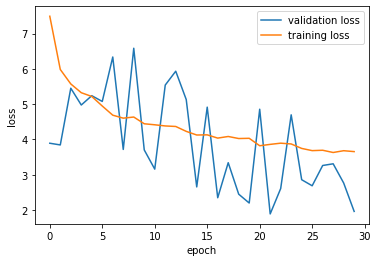

In [37]:
plt.plot(valid_losses, label='validation loss')
plt.plot(train_losses, label='training loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [38]:
df = pd.read_csv('test.csv')
df.drop(['Name', 'Ticket', 'Cabin'], inplace=True, axis=1)

In [39]:
df = pd.get_dummies(df, columns={'Sex'})
df = pd.get_dummies(df, columns={'Pclass'})
df = pd.get_dummies(df, columns={'Embarked'})

In [40]:
df['Age'] = pd.DataFrame(age_scaler.transform(df['Age'].values.reshape(-1, 1)), index=df.index)
df['SibSp'] = pd.DataFrame(sibsp_scaler.transform(df['SibSp'].values.reshape(-1, 1)), index=df.index)
df['Parch'] = pd.DataFrame(parch_scaler.transform(df['Parch'].values.reshape(-1, 1)), index=df.index)
df['Fare'] = pd.DataFrame(fare_scaler.transform(df['Fare'].values.reshape(-1, 1)), index=df.index)

In [41]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df['Age'].values.reshape(-1, 1))
df['Age'] = imp.transform(df['Age'].values.reshape(-1, 1))

In [42]:
df.tail()

,PassengerId,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
413,1305,0.045878,0.0,0.0,-0.241106,0,1,0,0,1,0,0,1
414,1306,0.744071,0.0,0.0,4.220455,1,0,1,0,0,1,0,0
415,1307,0.704071,0.0,0.0,-0.276497,0,1,0,0,1,0,0,1
416,1308,0.045878,0.0,0.0,-0.241106,0,1,0,0,1,0,0,1
417,1309,0.045878,1.0,1.0,0.391887,0,1,0,0,1,1,0,0


In [43]:
df.tail()

,PassengerId,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
413,1305,0.045878,0.0,0.0,-0.241106,0,1,0,0,1,0,0,1
414,1306,0.744071,0.0,0.0,4.220455,1,0,1,0,0,1,0,0
415,1307,0.704071,0.0,0.0,-0.276497,0,1,0,0,1,0,0,1
416,1308,0.045878,0.0,0.0,-0.241106,0,1,0,0,1,0,0,1
417,1309,0.045878,1.0,1.0,0.391887,0,1,0,0,1,1,0,0


In [44]:
test_dataset = TitanicDataset(df)
titanic_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [45]:
model = NeuralNetwork().cuda()
model.load_state_dict(torch.load('saved_model.pth'))
model.eval()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [46]:
preds = list()
for data in titanic_test_loader:
  if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()
  target = model(data)
  preds = preds + target.tolist()
preds[:10]

[[0.2390332818031311],
 [0.7260140776634216],
 [0.2503657341003418],
 [0.1977900266647339],
 [0.4712918698787689],
 [0.4288618862628937],
 [1.3009353876113892],
 [0.16989129781723022],
 [0.3449457287788391],
 [0.3464501202106476]]

In [47]:
def func(i):
  return i[0]
preds = list(map(lambda i:func(i), preds))
result = pd.DataFrame(index = df['PassengerId'])
result['Survived'] = pd.DataFrame(preds, index=result.index)
result['Survived'] = np.where(result['Survived'] < .5, 0, 1)
result.to_csv('submission.csv')

In [48]:
make_dot(yhat, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

'rnn_torchviz.png'